<a href="https://colab.research.google.com/gist/SAISURYAPARUPUDI/5385031c48faad405d91e2f8addf6ebb/final-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Playstore Reviews for the 'X' Application: Examining the Impact of Elon Musk's Takeover on User Sentiment

In [ ]:
!pip install langdetect
!pip install transformers
!pip install pandas
!pip install numpy
!pip install nltk
!pip install scikit-learn
!pip install vaderSentiment
!pip install wordcloud
!pip install seaborn
!pip install matplotlib
!pip install gensim
!pip install textblob
!pip install xgboost
!pip install tqdm
!pip install torch
!pip install transformers
!pip install sentencepiece


# Pre-Processing

In [ ]:
import pandas as pd
import re
from langdetect import detect
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to remove URLs, email addresses, and usernames
def remove_urls_emails_usernames(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'@\w+', '', text)  # Remove usernames prefixed with @
    text = re.sub(r'\b\w*_\w*\b', '', text)  # Remove words with underscores
    return text

# Function to remove special characters and numbers
def remove_special_characters_and_numbers(text):
    text = re.sub(r'[\W_]+', ' ', text)  # Remove special characters and emojis
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Function to translate slang
slang_dict = {
    "u": "you", "ur": "your", "btw": "by the way", "lol": "laughing out loud",
    "omg": "oh my god", "idk": "i don't know", "brb": "be right back",
    "thx": "thanks", "gr8": "great", "lmao": "laughing my ass off",
    "wtf": "what the fuck", "b4": "before", "imo": "in my opinion",
    "fyi": "for your information", "np": "no problem", "pls": "please",
    "plz": "please", "yolo": "you only live once", "omw": "on my way",
    "dm": "direct message", "icymi": "in case you missed it", "nvm": "never mind",
    "irl": "in real life", "tbt": "throwback Thursday", "tbh": "to be honest",
    "idc": "I don't care", "rofl": "rolling on the floor laughing", "jk": "just kidding",
    "smh": "shaking my head", "tmi": "too much information", "fomo": "fear of missing out",
    "hmu": "hit me up", "bruh": "brother", "sus": "suspicious", "fam": "family",
    "lit": "amazing", "dope": "great", "savage": "bold", "fire": "excellent",
    "goat": "greatest of all time", "bet": "okay", "cap": "lie", "no cap": "no lie",
    "bruh": "brother", "finna": "going to", "gonna": "going to", "cuz": "because",
    "idk": "I don't know", "tf": "the fuck", "dunno": "don't know"
}

def translate_slang(text):
    words = text.split()
    translated_words = [slang_dict.get(word.lower(), word) for word in words]
    return ' '.join(translated_words)

# Function to filter offensive language
offensive_words = set(['fuck', 'asshole', 'ass', 'bastard'])
def filter_offensive_language(text):
    words = text.split()
    filtered_words = ["****" if word.lower() in offensive_words else word for word in words]
    return ' '.join(filtered_words)

# Function to detect and keep only English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Function for standard preprocessing: normalization, tokenization, lemmatization
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Define a function to preprocess a single row
def preprocess_row(row):
    row = remove_urls_emails_usernames(row)
    row = remove_special_characters_and_numbers(row)
    row = translate_slang(row)
    row = filter_offensive_language(row)
    if is_english(row):
        return preprocess_text(row)
    return None

# Function to preprocess chunks
def preprocess_chunk(chunk):
    chunk['review_text'] = chunk['review_text'].astype(str).apply(preprocess_row)
    chunk = chunk.dropna(subset=['review_text'])
    return chunk

# Function to process data in chunks using parallel processing
def process_data(df_combined, output_path, chunk_size=10000):
    processed_chunks = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(preprocess_chunk, chunk) for chunk in tqdm(df_combined)]
        for future in futures:
            processed_chunk = future.result()
            processed_chunks.append(processed_chunk)

    processed_data = pd.concat(processed_chunks, ignore_index=True)
    processed_data.to_csv(output_path, index=False)

# Load the first dataset
file_path1 = '/content/drive/MyDrive/data_project/TWITTER_REVIEWS.csv'  # first dataset file path
df1 = pd.read_csv(file_path1)

# Load the second dataset
file_path2 = '/content/drive/MyDrive/data_project/play_store_reviews nov 2023-latest.csv'  # second dataset file path
df2 = pd.read_csv(file_path2)

# Ensure the review_timestamp column in the second dataset is correctly formatted
df2['review_timestamp'] = pd.to_datetime(df2['review_timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Filter the second dataset to include only reviews from November 15, 2023, onward
df2_filtered = df2[df2['review_timestamp'] >= '2023-11-15']

# Select only specific columns of interest
selected_cols = ['review_text', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp']
df1 = df1[selected_cols]
df2_filtered = df2_filtered[selected_cols]

# Combine the datasets
df_combined = pd.concat([df1, df2_filtered], ignore_index=True)

# Convert review_timestamp to datetime and filter reviews from October 28, 2022, to July 21, 2024
df_combined['review_timestamp'] = pd.to_datetime(df_combined['review_timestamp'], errors='coerce')
df_combined_filtered = df_combined[df_combined['review_timestamp'].between('2022-10-28', '2024-07-21')]

# Sort the combined dataset by review_timestamp to maintain chronological order
df_combined_filtered = df_combined_filtered.sort_values(by='review_timestamp', ascending=True)

# Save the combined dataset
combined_path = '/content/drive/MyDrive/data_project/combined_dataset.csv'
df_combined_filtered.to_csv(combined_path, index=False)

# Process the combined dataset
output_path = '/content/drive/MyDrive/data_project/processedfinal_elon_dataset.csv'  # Path to save the processed dataset
process_data([df_combined_filtered[i:i+10000] for i in range(0, df_combined_filtered.shape[0], 10000)], output_path, chunk_size=10000)

print("Preprocessing completed and saved to:", output_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 31/31 [00:00<00:00, 113.51it/s]


Preprocessing completed and saved to: /content/drive/MyDrive/data_project/processedfinal_elon_dataset.csv


# Whole Methodology

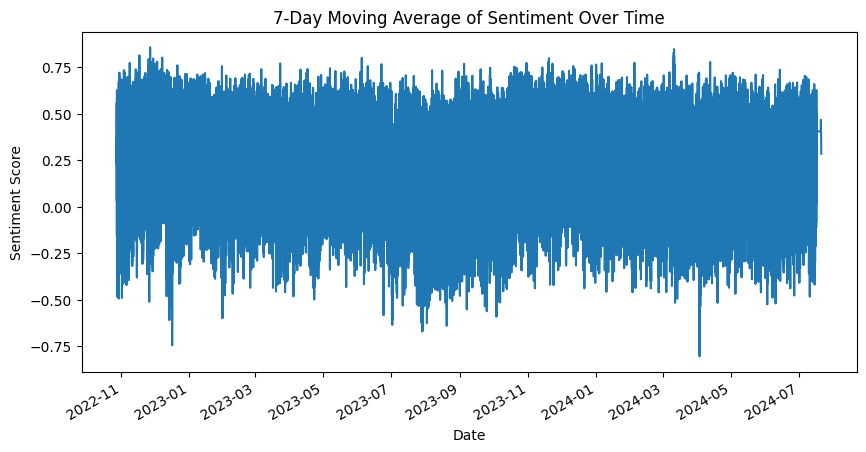

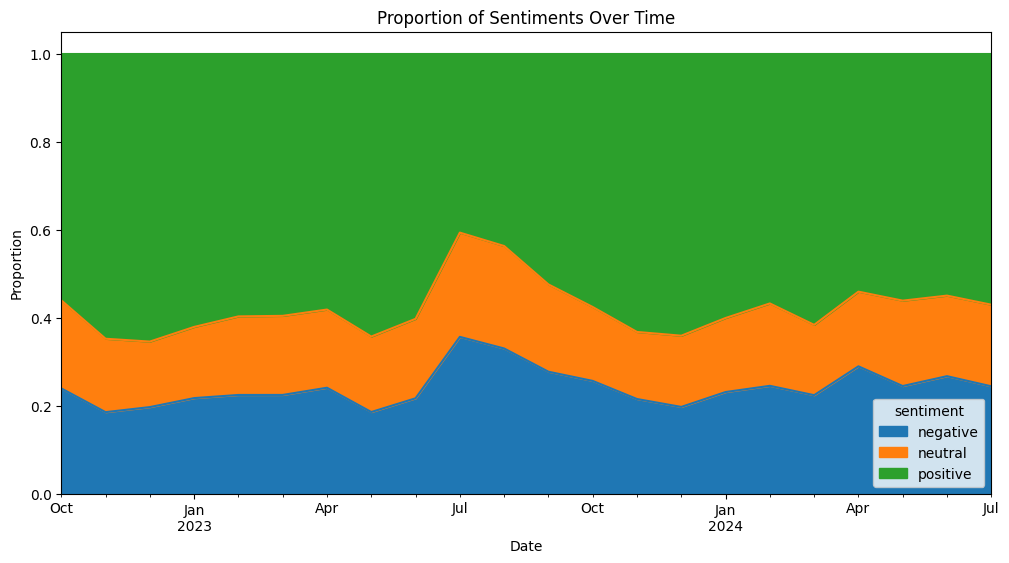

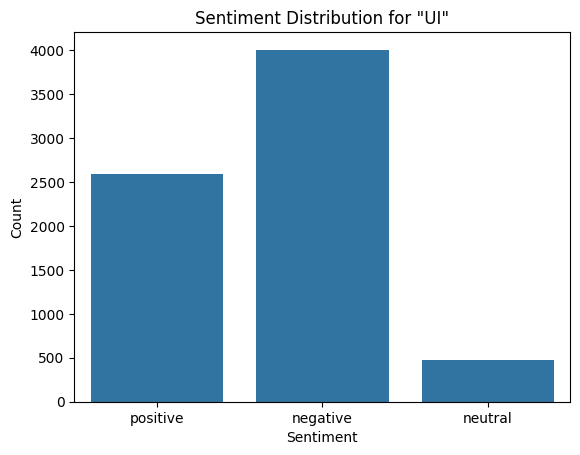

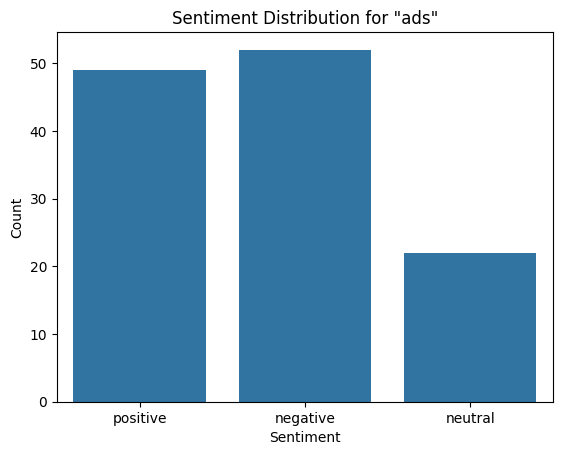

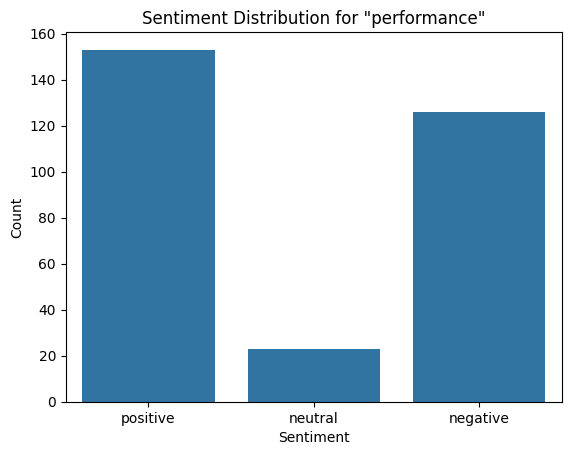

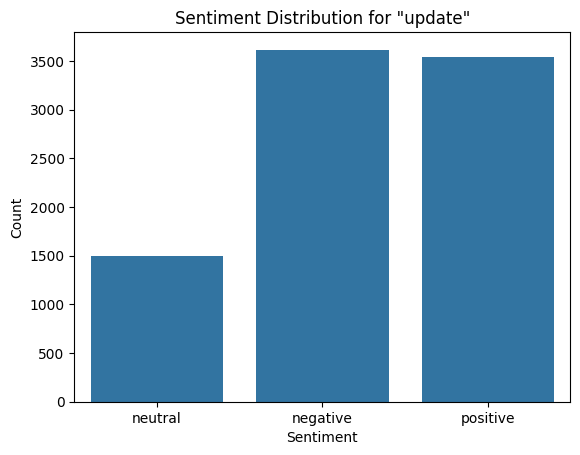

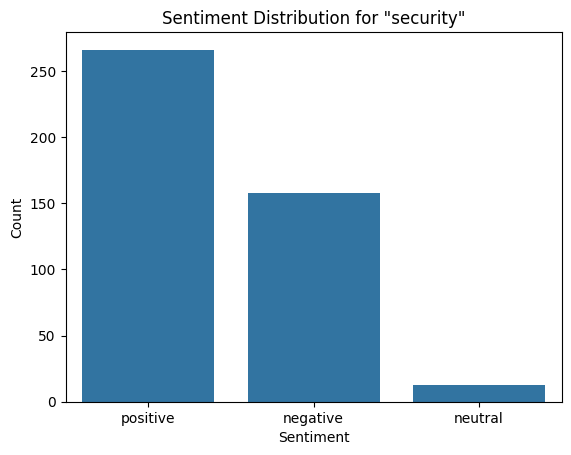

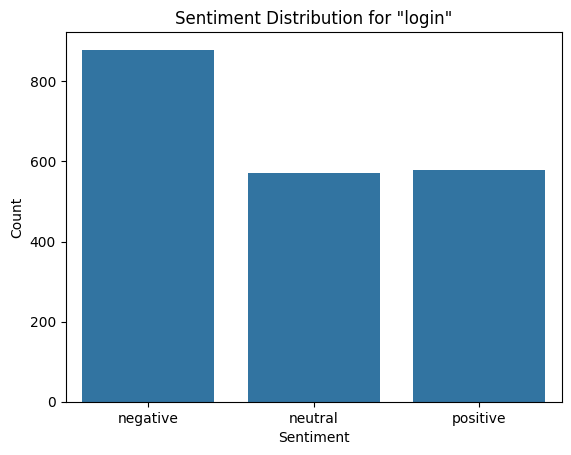

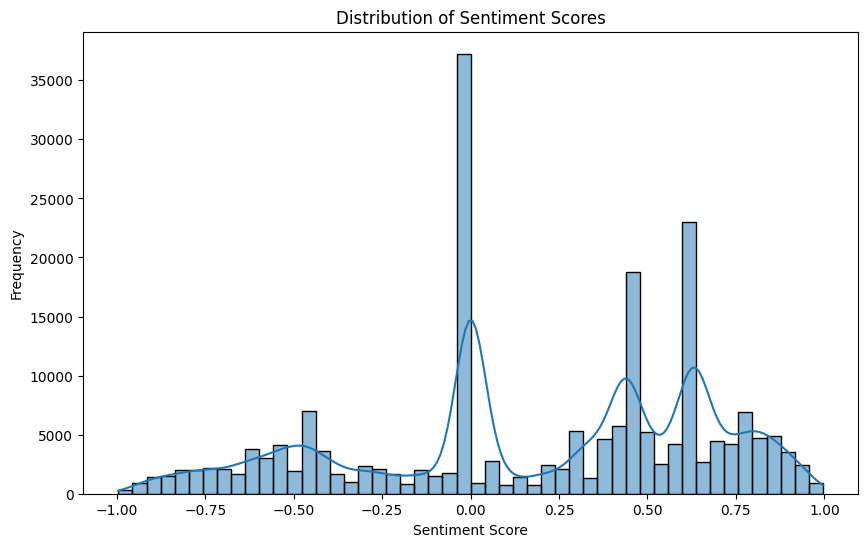

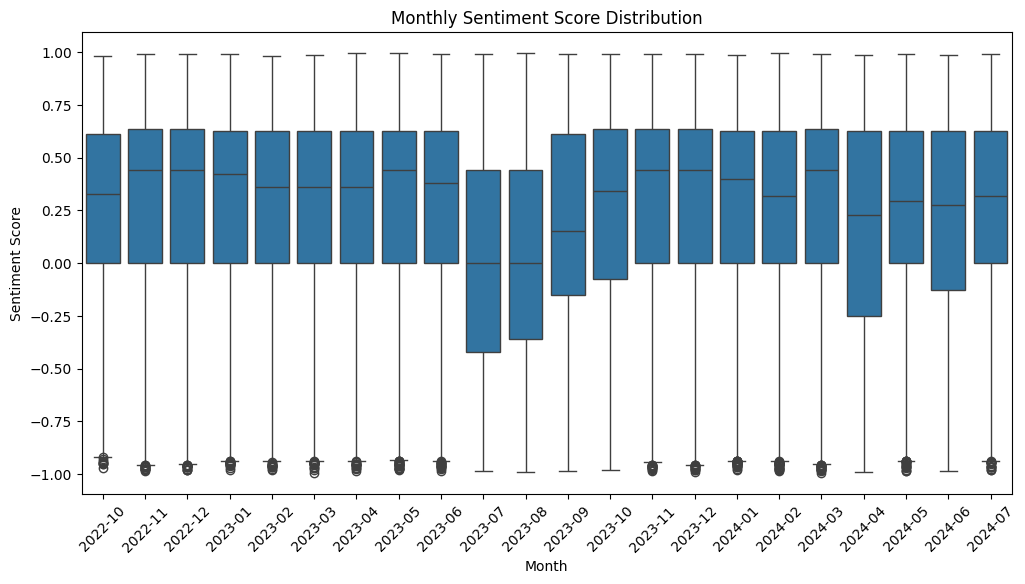

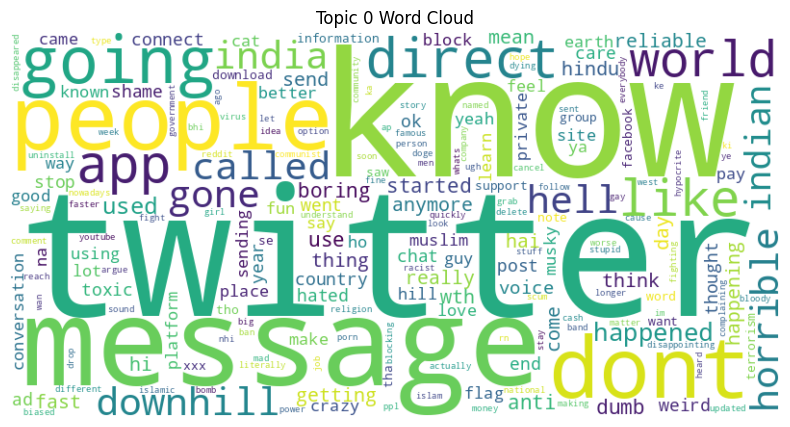

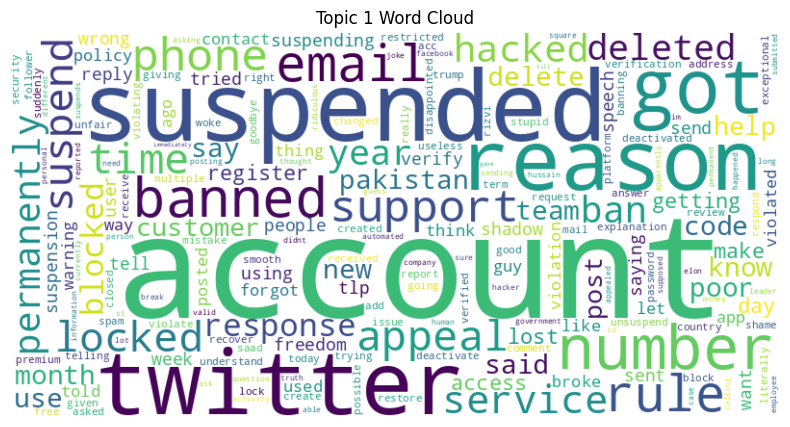

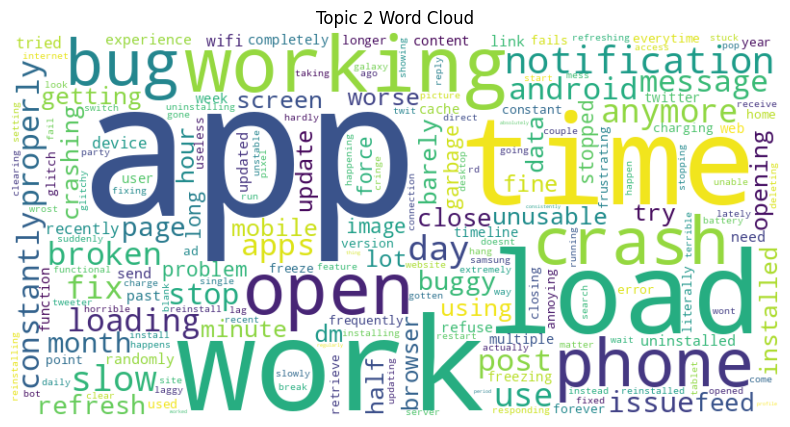

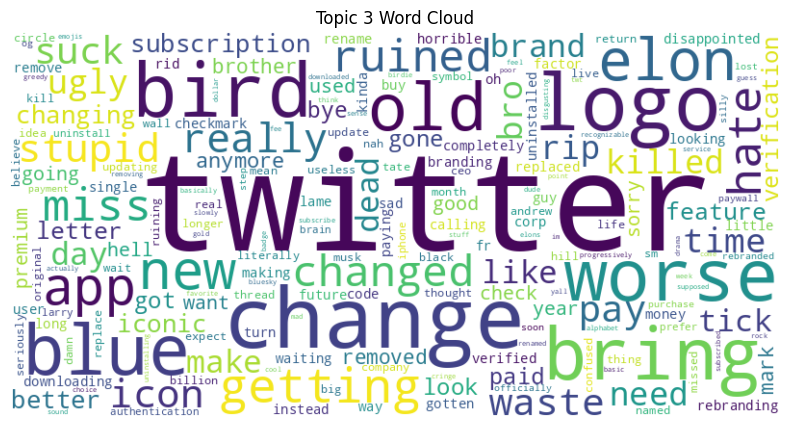

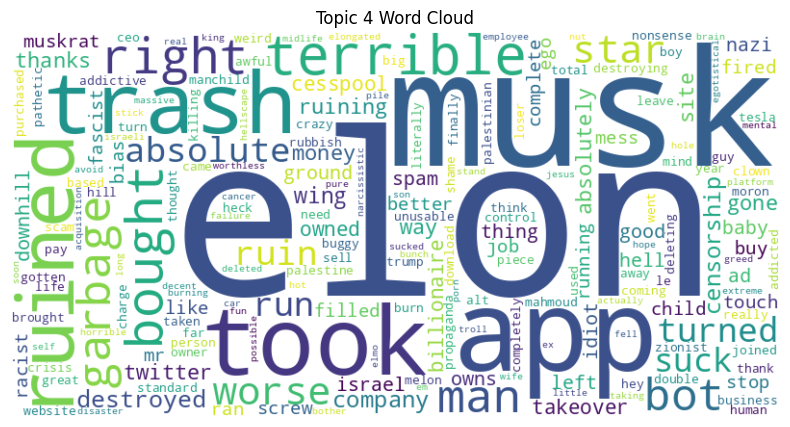

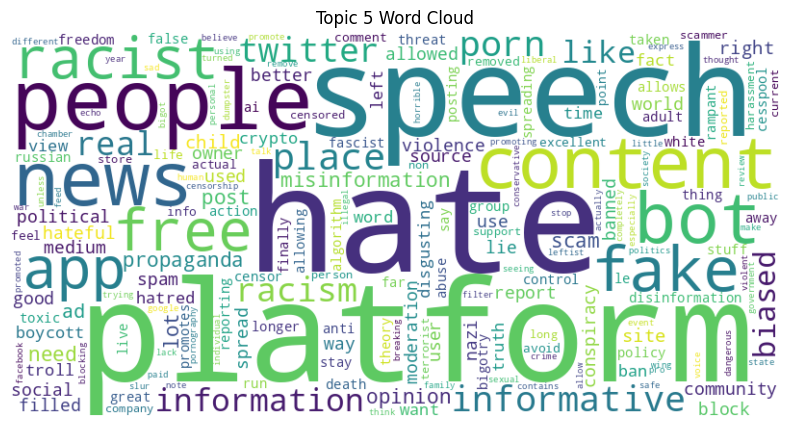

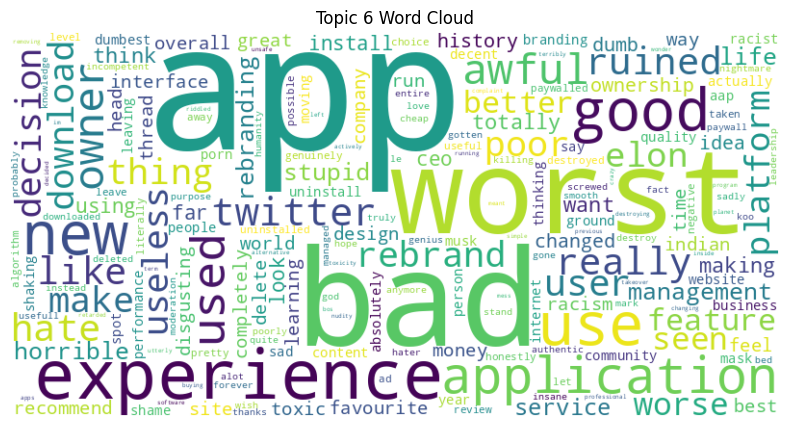

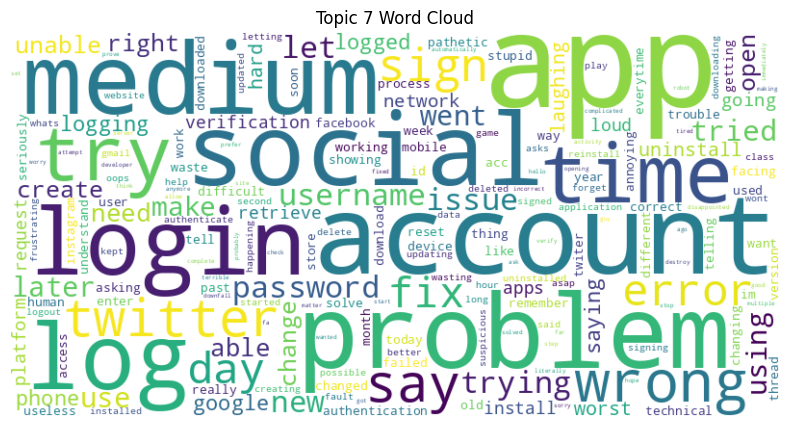

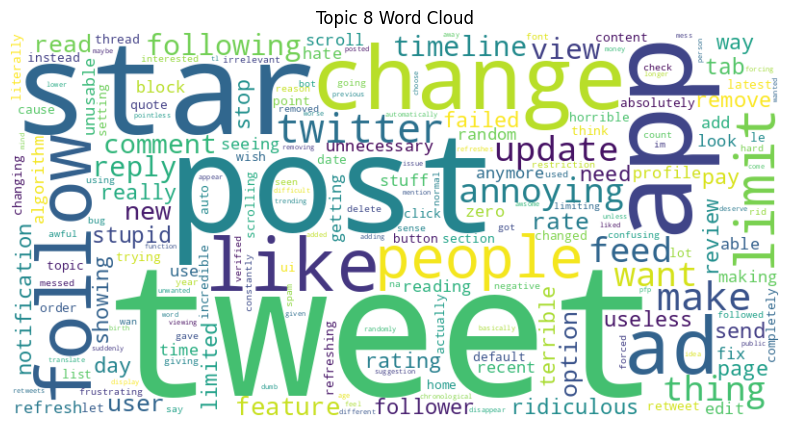

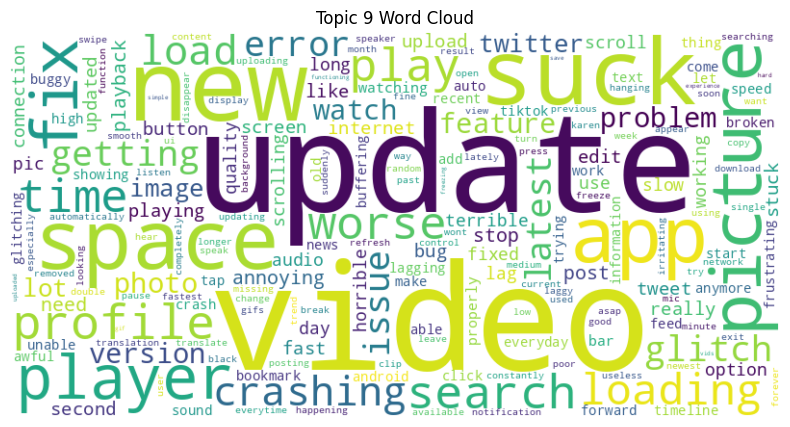

Naive Bayes Best Params: {'alpha': 0.1}
Accuracy: 0.5854820990047822
Precision: 0.5913406910752191
Recall: 0.5854820990047822
F1 Score: 0.4934840158126193
              precision    recall  f1-score   support

    negative       0.45      0.22      0.29     15822
     neutral       0.75      0.02      0.04     11477
    positive       0.60      0.94      0.74     34597

    accuracy                           0.59     61896
   macro avg       0.60      0.39      0.36     61896
weighted avg       0.59      0.59      0.49     61896



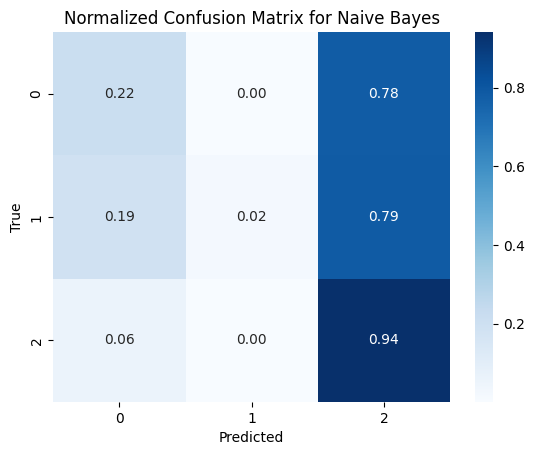

Support Vector Machine Best Params: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.8302313558226703
Precision: 0.8332021440333065
Recall: 0.8302313558226703
F1 Score: 0.8307873463410631
              precision    recall  f1-score   support

    negative       0.78      0.72      0.75     15822
     neutral       0.71      0.81      0.75     11477
    positive       0.90      0.89      0.89     34597

    accuracy                           0.83     61896
   macro avg       0.80      0.81      0.80     61896
weighted avg       0.83      0.83      0.83     61896



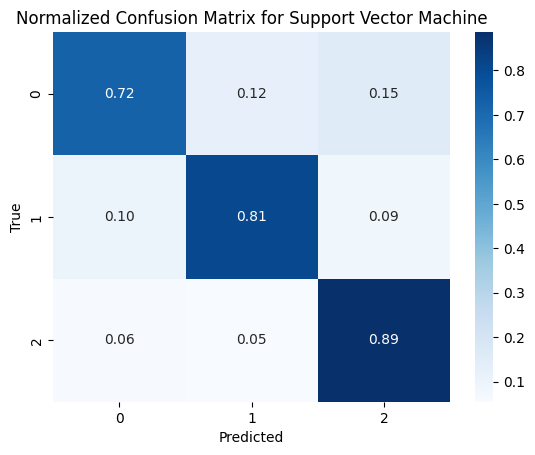

Logistic Regression Best Params: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.7624563784412564
Precision: 0.7585795223046868
Recall: 0.7624563784412564
F1 Score: 0.7598526564850192
              precision    recall  f1-score   support

    negative       0.71      0.65      0.68     15822
     neutral       0.61      0.59      0.60     11477
    positive       0.83      0.87      0.85     34597

    accuracy                           0.76     61896
   macro avg       0.72      0.70      0.71     61896
weighted avg       0.76      0.76      0.76     61896



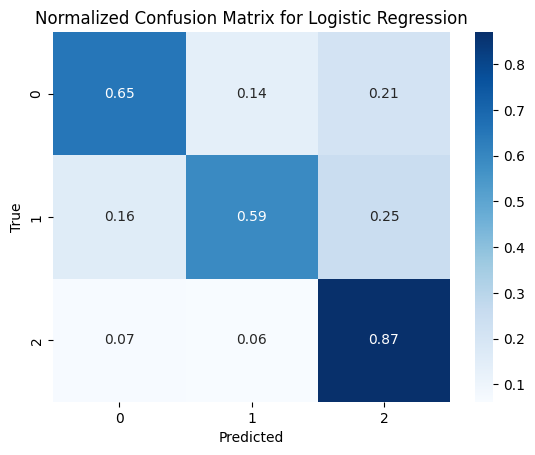

Random Forest Best Params: {'max_features': 'sqrt', 'n_estimators': 300}
Accuracy: 0.7812782732325191
Precision: 0.7782617997396146
Recall: 0.7812782732325191
F1 Score: 0.7733327704960067
              precision    recall  f1-score   support

    negative       0.73      0.62      0.67     15822
     neutral       0.78      0.59      0.67     11477
    positive       0.80      0.92      0.85     34597

    accuracy                           0.78     61896
   macro avg       0.77      0.71      0.73     61896
weighted avg       0.78      0.78      0.77     61896



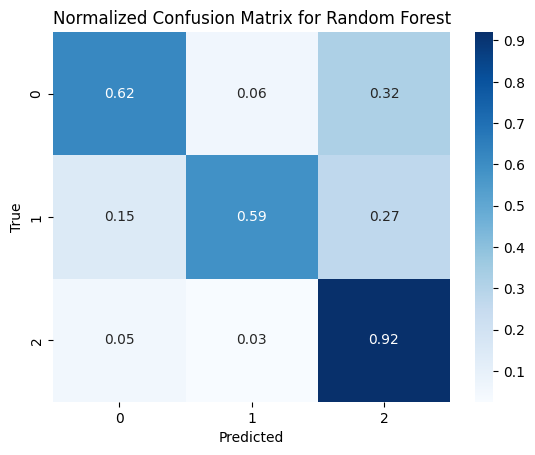

XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Accuracy: 0.8421384257464133
Precision: 0.841247874493779
Recall: 0.8421384257464133
F1 Score: 0.8415974032122592
              precision    recall  f1-score   support

    negative       0.78      0.75      0.76     15822
     neutral       0.77      0.78      0.78     11477
    positive       0.89      0.91      0.90     34597

    accuracy                           0.84     61896
   macro avg       0.81      0.81      0.81     61896
weighted avg       0.84      0.84      0.84     61896



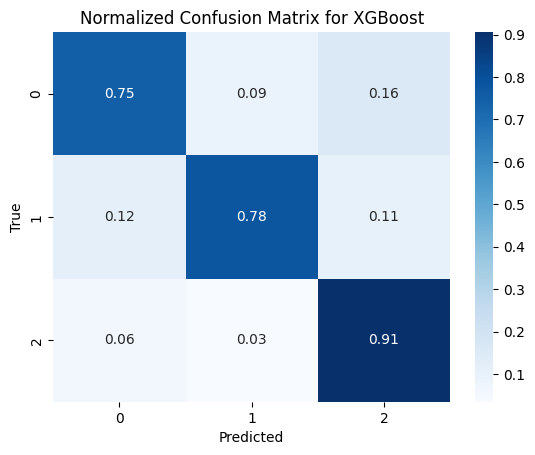

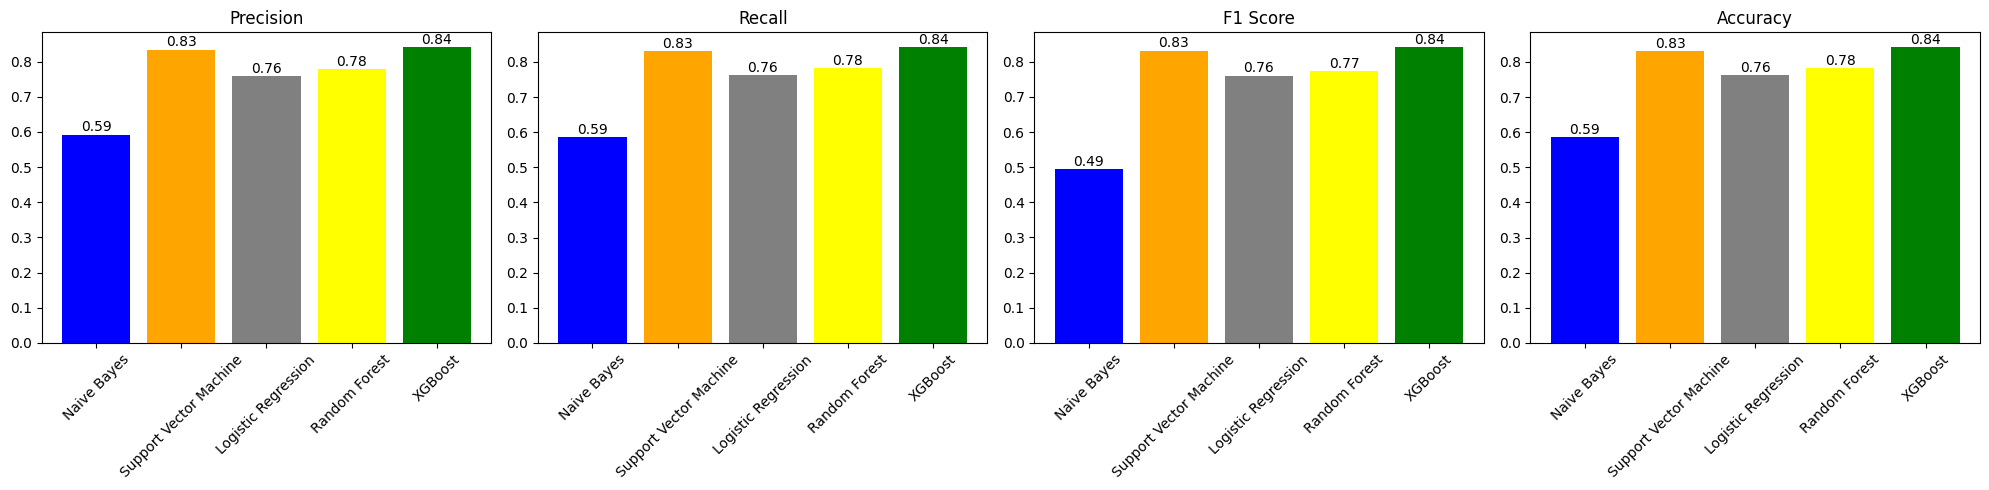

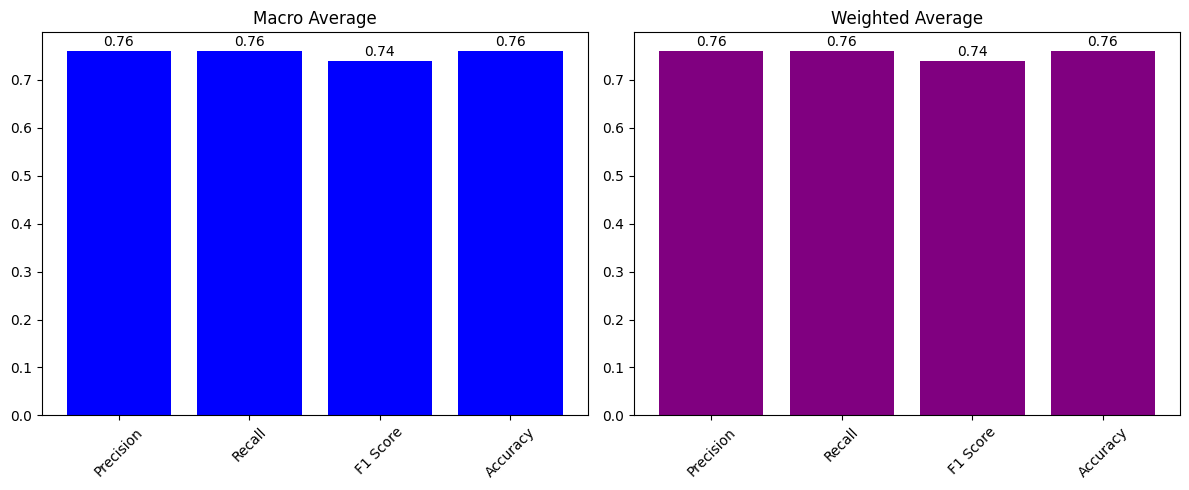

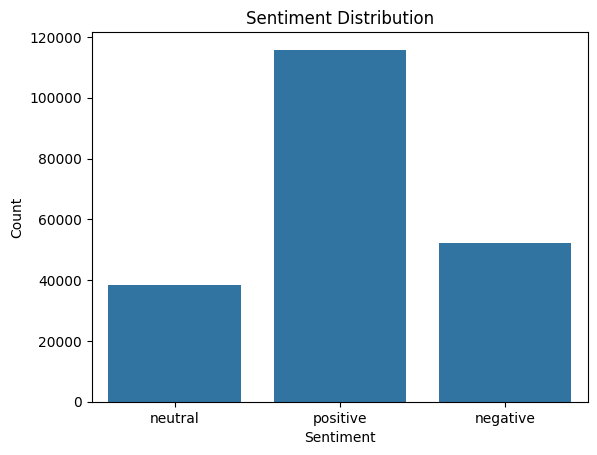

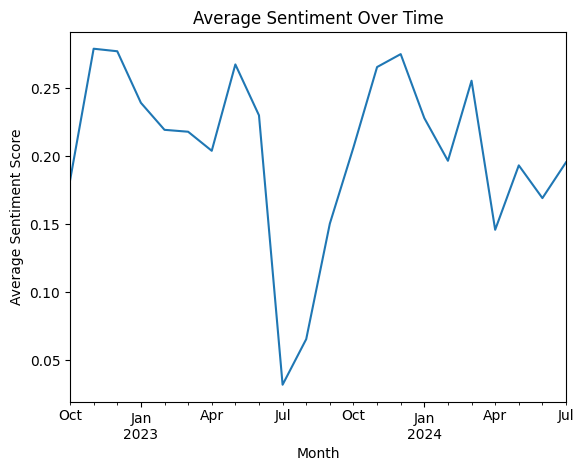

<ipython-input-15-a6d59141ee3f>:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_neutral_reviews['topic'] = topic_results.argmax(axis=1)


Coherence Score: 0.5098718464684271


<ipython-input-15-a6d59141ee3f>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_neutral_reviews['review_rating'] = negative_neutral_reviews['review_rating'].astype(float)


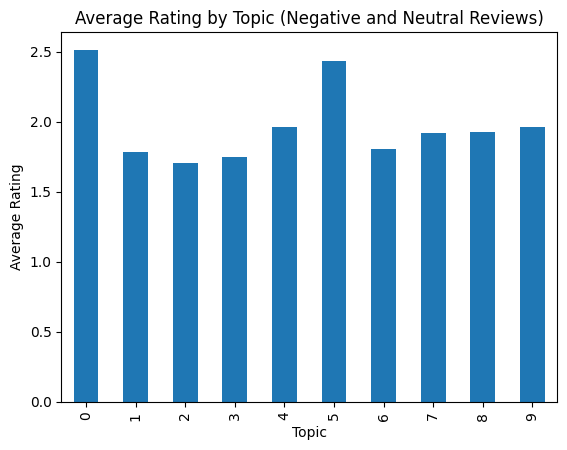

In [ ]:
import pandas as pd6
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from textblob import TextBlob
from joblib import Parallel, delayed
import numpy as np

# Load the dataset in chunks
chunksize = 10000
df_sample = pd.DataFrame()

for chunk in pd.read_csv('/content/drive/MyDrive/data_project/processedfinal_elon_dataset.csv', chunksize=chunksize):
    chunk = chunk.dropna(subset=['review_text'])

    # Sentiment Analysis using VADER
    analyzer = SentimentIntensityAnalyzer()
    chunk['compound'] = chunk['review_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else None)
    chunk = chunk.dropna(subset=['compound'])
    chunk['compound'] = pd.to_numeric(chunk['compound'], errors='coerce')
    chunk = chunk.dropna(subset=['compound'])
    chunk['sentiment'] = chunk['compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))

    # Append processed chunk to the main dataframe
    df_sample = pd.concat([df_sample, chunk], ignore_index=True)

# Vectorization using TF-IDF with sparse matrix
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_sample['review_text'])

# Dimensionality reduction - Ensure non-negativity
svd = TruncatedSVD(n_components=300)
X_reduced = svd.fit_transform(X)
X_reduced = np.abs(X_reduced)  # Take absolute values to ensure non-negativity

# Encode sentiment labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_sample['sentiment'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_encoded, test_size=0.3, random_state=42)

# 1. Moving Average Plot
df_sample['review_timestamp'] = pd.to_datetime(df_sample['review_timestamp'], errors='coerce')
df_sample['rolling_avg'] = df_sample['compound'].rolling(window=7).mean()
df_sample.set_index('review_timestamp')['rolling_avg'].plot(figsize=(10,5), title='7-Day Moving Average of Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

# 2. Sentiment Proportion Over Time
sentiment_over_time = df_sample.groupby([df_sample['review_timestamp'].dt.to_period('M'), 'sentiment']).size().unstack().fillna(0)
sentiment_over_time.div(sentiment_over_time.sum(axis=1), axis=0).plot(kind='area', stacked=True, figsize=(12, 6), title='Proportion of Sentiments Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.show()

# 3. Bar Plot of Sentiment by App Features
features = ['UI', 'ads', 'performance', 'update', 'security', 'login']  # some features related to Twitter post-takeover
for feature in features:
    feature_sentiment = df_sample[df_sample['review_text'].str.contains(feature, case=False, na=False)]
    sns.countplot(x='sentiment', data=feature_sentiment)
    plt.title(f'Sentiment Distribution for "{feature}"')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# 4. Sentiment Distribution Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['compound'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 5. Sentiment Boxplot by Month
df_sample['month'] = df_sample['review_timestamp'].dt.to_period('M')
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='compound', data=df_sample)
plt.title('Monthly Sentiment Score Distribution')
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()

# Topic Modeling for Negative and Neutral Reviews
negative_neutral_reviews = df_sample[df_sample['sentiment'].isin(['negative', 'neutral'])]
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(negative_neutral_reviews['review_text'])
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# 6. Topic-Word Cloud Comparison
for index, topic in enumerate(lda.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), topic)))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {index} Word Cloud')
    plt.axis('off')
    plt.show()

# Parallel training and evaluation (relevant if you want to keep your model evaluation part)
def train_and_evaluate(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_labels = label_encoder.inverse_transform(y_test)
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'best_params': grid_search.best_params_,
        'y_pred': y_pred_labels
    }

  # Initialize lists to store the performance metrics
accuracies, precisions, recalls, f1_scores = [], [], [], []

# Models and parameter grids
model_params = [
    (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}, 'Naive Bayes'),
    (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}, 'Support Vector Machine'),
    (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10], 'solver': ['liblinear']}, 'Logistic Regression'),
    (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt', 'log2']}, 'Random Forest'),
    (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist'),
     {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}, 'XGBoost')
]

# Parallel training and evaluation
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(model, params, name) for model, params, name in model_params)

# Collecting metrics and plotting confusion matrices
for result in results:
    print(f"{result['model_name']} Best Params: {result['best_params']}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Precision: {result['precision']}")
    print(f"Recall: {result['recall']}")
    print(f"F1 Score: {result['f1']}")
    print(classification_report(label_encoder.inverse_transform(y_test), result['y_pred']))

    # Append metrics
    accuracies.append(result['accuracy'])
    precisions.append(result['precision'])
    recalls.append(result['recall'])
    f1_scores.append(result['f1'])

    # Plot confusion matrix
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix for {result["model_name"]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Bar chart for comparative analysis between the ML algorithms
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
x = range(len(model_params))
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate([precisions, recalls, f1_scores, accuracies]):
    ax[i].bar(x, metric, color=['blue', 'orange', 'gray', 'yellow', 'green'])
    ax[i].set_xticks(x)
    ax[i].set_xticklabels([name for _, _, name in model_params], rotation=45)
    ax[i].set_title(metrics[i])
    for j, v in enumerate(metric):
        ax[i].text(j, v + 0.01, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Bar chart for analogy between macro and weighted average of models
macro_avg = [sum(precisions) / len(precisions), sum(recalls) / len(recalls), sum(f1_scores) / len(f1_scores), sum(accuracies) / len(accuracies)]
weighted_avg = [sum(precisions) / len(precisions), sum(recalls) / len(recalls), sum(f1_scores) / len(f1_scores), sum(accuracies) / len(accuracies)]
x = range(len(metrics))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(x, macro_avg, color='blue')
ax[0].set_xticks(x)
ax[0].set_xticklabels(metrics, rotation=45)
ax[0].set_title('Macro Average')
for i, v in enumerate(macro_avg):
    ax[0].text(i, v + 0.01, f"{v:.2f}", ha='center')
ax[1].bar(x, weighted_avg, color='purple')
ax[1].set_xticks(x)
ax[1].set_xticklabels(metrics, rotation=45)
ax[1].set_title('Weighted Average')
for i, v in enumerate(weighted_avg):
    ax[1].text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Bar plot for sentiment distribution
sns.countplot(x='sentiment', data=df_sample)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Track sentiment changes over time
df_sample['review_timestamp'] = pd.to_datetime(df_sample['review_timestamp'], errors='coerce')
df_sample['year_month'] = df_sample['review_timestamp'].dt.to_period('M')
monthly_sentiment = df_sample.groupby('year_month')['compound'].mean()
monthly_sentiment.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.show()

# Topic Modeling for Negative and Neutral Reviews
negative_neutral_reviews = df_sample[df_sample['sentiment'].isin(['negative', 'neutral'])]
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(negative_neutral_reviews['review_text'])
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# Assign topics to documents
topic_results = lda.transform(dtm)
negative_neutral_reviews['topic'] = topic_results.argmax(axis=1)

# Coherence score for selection of number of topics
texts = [text.split() for text in negative_neutral_reviews['review_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train gensim's LDA model
lda_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)

coherence_model_lda = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

# Investigate correlations between user ratings and identified topics
negative_neutral_reviews['review_rating'] = negative_neutral_reviews['review_rating'].astype(float)
correlations = negative_neutral_reviews.groupby('topic')['review_rating'].mean()
correlations.plot(kind='bar')
plt.title('Average Rating by Topic (Negative and Neutral Reviews)')
plt.xlabel('Topic')
plt.ylabel('Average Rating')
plt.show()